Two qubit errors validated against Egan paper
===============

This is a simulation of two qubit errors in an ion trap quantum computer to compare a qiskit noise model with experiments by Egan [1].  The noise model will be used on our simulation of the Steane code.  Different numbers of consecutive RXX gates are set up and the ground state probability simulated is compared with that observed by Egan.

Our simulation shows results broadly aligned with Egan.  For 16 gates we found a ground state probability of around 0.81(3) whilst Egan has a worst case of 0.78 and a best case of 0.87.

[1] Egan L, Debroy DM, Noel C, Risinger A, Zhu D, Biswas D, et al. Fault-Tolerant Operation of a Quantum Error-Correction Code. arXiv Available from: http://arxiv.org/abs/2009.11482

This is part of an MSc project on the Steane code.  Please see https://goldsmdn.github.io/ for full details.

Import the necessary function modules.

In [1]:
from qiskit import(
  QuantumCircuit,
  QuantumRegister,
  ClassicalRegister,
  execute,
  Aer)

from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
from qiskit.visualization import plot_histogram

import math
import matplotlib.pyplot as plt
import numpy as np

from helper_functions import (get_noise, mean_of_list, calculate_standard_error)

Define constants so the process flow can be controlled from one place:

In [2]:
SINGLE_GATE_SET = ['id', 'ry', 'rx']
TWO_GATE_SET = ['rxx']
BASIS_GATE_SET = SINGLE_GATE_SET + TWO_GATE_SET

SHOTS = 10000                             #Number of shots to run 
ITERATIONS  = 4                           #Number of runs
MEASURE_NOISE = 0.0046                    #Measurement noise 
SINGLE_GATE_DEPOLARISING = 0.0            #Single gate noise not relevant 
TWO_GATE_DEPOLARISING = 0.011             #Two gate noise
NOISE = True                              #Test with noise
GATE_DEPTH_REVERSE_LIST = [2, 4, 6, 8, 10, 12, 14, 16]               
GATES_DEPTH_NO_REVERSE_LIST = [8, 16]
GATE_DEPTH_CALCULATION = [0, 2, 4, 6, 8, 10, 12, 14, 16]  
PI = math.pi

SIMULATOR = Aer.get_backend('qasm_simulator')

Qubit 1 and Qubit 2 will each be unchanged with probability (1-p).  Both Qbit 1 and Qbit 2 will be unchanged with probability (1-p) ^ 2 which is close to 1-2p for small p.  When the qubits are changed then half the time this won't be detected by a projective measurement.  So the probability of the ground state after d gate is close to (1 - p) ^ d.

We simulate for both reversals and no reversals.

In [3]:
#Define lists used in simulations for graphs
simulation_probability_reverse = []
standard_error_reverse = []
simulation_probability_no_reverse = []
standard_error_no_reverse = []
gate_depth_plot_reverse = []
gate_depth_plot_no_reverse = []

In [4]:
for reverse in [True, False]:
    probability_list = []
    if reverse:
        gate_depth_list = GATE_DEPTH_REVERSE_LIST
    else:
        gate_depth_list = GATES_DEPTH_NO_REVERSE_LIST
    for gate_depth in gate_depth_list:
        probability_list = []
        for iteration in range(ITERATIONS):
            qr = QuantumRegister(2,'code_qubit')     # Two qubits
            cr = ClassicalRegister(2,'syndrome_bit') # two Syndrome bit
            qc = QuantumCircuit(qr,cr)
            qc.reset(qr[0])
            qc.reset(qr[1])
            for i in range(gate_depth):
                #if reversals apply XX gate if gate number is odd or inverse otherwise
                if i % 2 == 0:
                    qc.rxx(PI/4,qr[0],qr[1])
                else:
                    if reverse:
                        qc.rxx(-PI/4,qr[0],qr[1])
                    else:
                        qc.rxx(PI/4,qr[0],qr[1])

            qc.measure(qr, cr)
            noise_model = get_noise(MEASURE_NOISE, SINGLE_GATE_DEPOLARISING, TWO_GATE_DEPOLARISING,
                                    SINGLE_GATE_SET, TWO_GATE_SET)
            if NOISE:
                result = execute(qc, SIMULATOR, noise_model=noise_model, shots=SHOTS).result()
            else:
                result = execute(qc, SIMULATOR, shots=SHOTS).result()     
            counts = result.get_counts(qc)
            probability = counts.get('00') / SHOTS
            probability_list.append(probability)
        mean = mean_of_list(probability_list)  
        standard_deviation, standard_error = calculate_standard_error(probability_list)
        if reverse:
            simulation_probability_reverse.append(mean)
            standard_error_reverse.append(standard_error)
            gate_depth_plot_reverse.append(gate_depth)
            print(f'For {gate_depth} gates with reversal simulated mean ground state population is {probability:.4f}')
        else:
            simulation_probability_no_reverse.append(mean)
            standard_error_no_reverse.append(standard_error)
            gate_depth_plot_no_reverse.append(gate_depth)
            print(f'For {gate_depth} gates with no reversal simulated mean ground state population is {probability:.4f}. ')   
        print(f'  The standard error is {standard_error:.4f}')

For 2 gates with reversal simulated mean ground state population is 0.9649
  The standard error is 0.0008
For 4 gates with reversal simulated mean ground state population is 0.9447
  The standard error is 0.0011
For 6 gates with reversal simulated mean ground state population is 0.9230
  The standard error is 0.0009
For 8 gates with reversal simulated mean ground state population is 0.9008
  The standard error is 0.0008
For 10 gates with reversal simulated mean ground state population is 0.8844
  The standard error is 0.0022
For 12 gates with reversal simulated mean ground state population is 0.8537
  The standard error is 0.0015
For 14 gates with reversal simulated mean ground state population is 0.8386
  The standard error is 0.0015
For 16 gates with reversal simulated mean ground state population is 0.8153
  The standard error is 0.0027
For 8 gates with no reversal simulated mean ground state population is 0.8930. 
  The standard error is 0.0008
For 16 gates with no reversal simulat

Set up Egan's best fit lines

In [5]:
echoed_calculation = []
cumulative_calculation = []
theory_calculation = []
expected = (1 - TWO_GATE_DEPOLARISING)** gate_depth * (1 - MEASURE_NOISE)
for gate_depth in GATE_DEPTH_CALCULATION:
    echoed = (1 - MEASURE_NOISE) -  gate_depth * 0.007
    cumulative = (1 - MEASURE_NOISE) - gate_depth * 0.015
    theory = (1 - TWO_GATE_DEPOLARISING)** gate_depth * (1 - MEASURE_NOISE)
    echoed_calculation.append(echoed)
    cumulative_calculation.append(cumulative)
    theory_calculation.append(theory)
    print(f'For {gate_depth} gates')
    print(f'Egan  echoed best fit line is {echoed:.4f}')
    print(f'Egan cumulative best fit line is {cumulative:.4f}')
    print(f'Calculation based on depolarising noise is {theory:.4f}')

For 0 gates
Egan  echoed best fit line is 0.9954
Egan cumulative best fit line is 0.9954
Calculation based on depolarising noise is 0.9954
For 2 gates
Egan  echoed best fit line is 0.9814
Egan cumulative best fit line is 0.9654
Calculation based on depolarising noise is 0.9736
For 4 gates
Egan  echoed best fit line is 0.9674
Egan cumulative best fit line is 0.9354
Calculation based on depolarising noise is 0.9523
For 6 gates
Egan  echoed best fit line is 0.9534
Egan cumulative best fit line is 0.9054
Calculation based on depolarising noise is 0.9315
For 8 gates
Egan  echoed best fit line is 0.9394
Egan cumulative best fit line is 0.8754
Calculation based on depolarising noise is 0.9111
For 10 gates
Egan  echoed best fit line is 0.9254
Egan cumulative best fit line is 0.8454
Calculation based on depolarising noise is 0.8912
For 12 gates
Egan  echoed best fit line is 0.9114
Egan cumulative best fit line is 0.8154
Calculation based on depolarising noise is 0.8717
For 14 gates
Egan  echoed

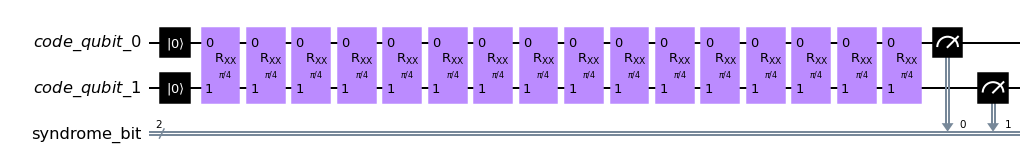

In [6]:
qc.draw(output='mpl', filename = 'Egan_two_qubit_circuit.jpg', fold=60)

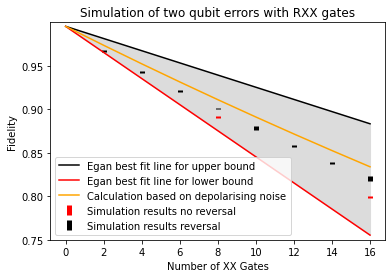

In [7]:
#graph constants
YMIN = 0.75
YMAX = 1.000
YTICK = 0.05
BAR_WIDTH = 5

#graph
title_text = "Ground state probabilty against number of Clifford Gates"
plt.errorbar(gate_depth_plot_no_reverse, simulation_probability_no_reverse, yerr = standard_error_no_reverse, 
             fmt = 'none', elinewidth = BAR_WIDTH, label =  'Simulation results no reversal', color = 'red')           
plt.errorbar(gate_depth_plot_reverse, simulation_probability_reverse, yerr = standard_error_reverse, 
            fmt = 'none', elinewidth = BAR_WIDTH, label = 'Simulation results reversal', color = 'black')
plt.plot(GATE_DEPTH_CALCULATION, echoed_calculation, label = "Egan best fit line for upper bound" , color="black")
plt.plot(GATE_DEPTH_CALCULATION, cumulative_calculation, label = "Egan best fit line for lower bound" , color="red")
plt.plot(GATE_DEPTH_CALCULATION, theory_calculation, label = "Calculation based on depolarising noise", color="orange")
plt.fill_between(GATE_DEPTH_CALCULATION, echoed_calculation, cumulative_calculation, color = '#dcdcdc')

plt.title('Simulation of two qubit errors with RXX gates')
plt.xlabel('Number of XX Gates')
plt.ylabel('Fidelity')  
plt.legend()
plt.ylim(YMIN, YMAX)
plt.xticks(np.arange(0, 18, 2))
plt.yticks(np.arange(YMIN, YMAX, YTICK))
fname = "RXX_gate_two_qubit_errors_graph.png"
plt.savefig(fname)

The results from Egan for comparison are shown below.  We expected that since we have used an average error our results are intermediate between the bands shown by Egan.

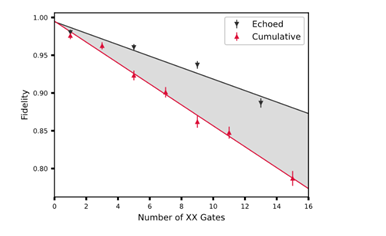